<a href="https://colab.research.google.com/github/goulartsursula/DisciplinasUERJ/blob/master/Estrutura%20da%20Materia%203/EspectroscopiaGama.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Estrutura da Matéria III**

Modalidade: Experimental

Alunos: Danielle Lessa, Tayan Sequeira e Úrsula Goulart

Professor: Dr. Wagner de Paula


---

# Experimento 2: Espectroscopia de Raios Gama

Objetivo: Encontrar um método de calibração utilizando os conjuntos de dados do Césio 137, Sódio 22 e Bário 133, a fim de determinar os isótopos **A**, **B**, **C**, **D** e **E**.

In [215]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

| Isótopo  |  Meia-vida  | Picos de emissão $\gamma$ de interesse |
| :-----:  |  :-------:  | :------------------------------------: |
| Cs-137   |  30,2 anos  | 662 keV                                |
| Ba-133   |  10,5 anos  | 81/ 353 keV                            |
| Na-22    |  2,60 anos  | 511/ 1275 keV                          |

Fonte: [http://www.nucleide.org/Laraweb/index.php](http://www.nucleide.org/Laraweb/index.php)

## 1. Evento de Fundo

É necessário fazer o plot dos eventos de fundo, para que posteriormente se faça uma comparação visual com os gráficos dos demais espectros, a fim de entender se os picos vistos é sinal ou ruído. Quando igual ou muito próximo do pico encontrado nos dados do _background_, isso significa que o pico do espectro do isótopo analisado é ruído.


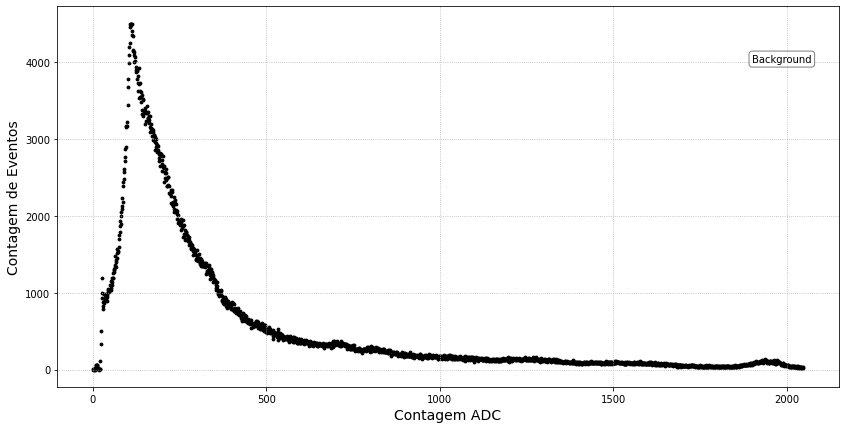

In [216]:
dataBack = pd.read_table('background.tsv', skiprows=22)

fig, ax = plt.subplots(figsize=(14,7))
plt.scatter(dataBack['Chan'], dataBack['Counts'], s=8, color='black')
plt.xlabel('Contagem ADC', fontsize = '14')
plt.ylabel('Contagem de Eventos', fontsize = '14')
ax.text(1900, 4000, 'Background', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.savefig('background.png', transparent = True)
plt.grid(linestyle='dotted')


In [217]:
print(dataBack.loc[0:500].nlargest(3, 'Counts'),'\n')
print(dataBack.loc[0:500]['Counts'].idxmax())
peakBack = dataBack.iloc[dataBack.loc[0:500]['Counts'].idxmax()]['Chan']


     Chan  Unnamed: 1  Counts
108   108         NaN    4501
112   112         NaN    4500
109   109         NaN    4499 

108


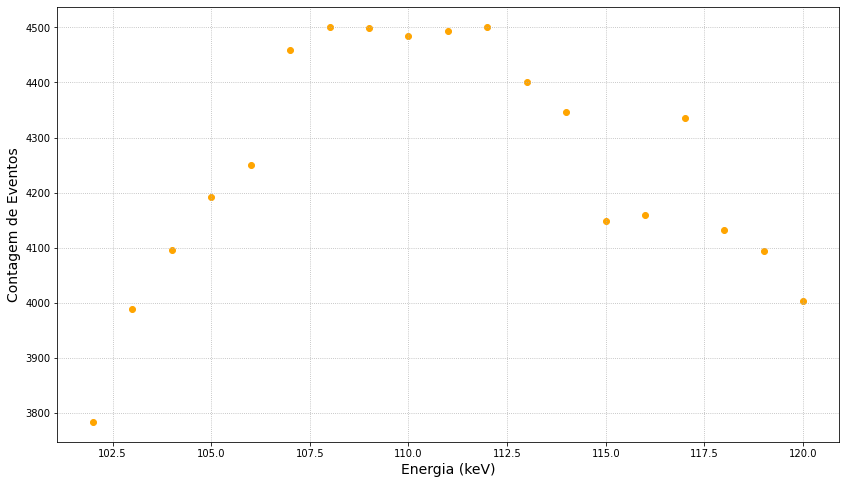

In [218]:
dataBack_peak = dataBack[(dataBack['Chan']>=102)&(dataBack['Chan']<=120)]

fig = plt.subplots(figsize=(14,8))
plt.scatter(dataBack_peak['Chan'], dataBack_peak['Counts'], c='orange')
plt.xlabel('Energia (keV)', fontsize='14')
plt.ylabel('Contagem de Eventos', fontsize='14')
plt.grid(linestyle='dotted')

In [219]:
def GaussBack(x, A, mean, sigma): #Gaussiana para o primeiro pico
    return A * np.exp(-0.5 * np.square((x - mean) / sigma))

sigma = np.sqrt(ydataBack)
p0 = (1000, 112.4, 18) #Condições iniciais: valor máximo de y, estimativa da média, xmax - xmin

poptBack, pcovBack = curve_fit(GaussBack, xdataBack, ydataBack, sigma=sigma, p0=p0) #print A, mean, sigma

errorBack = [np.sqrt(pcovBack[i, i]) for i in np.arange(3)] #Diagonal principal da matriz

In [220]:
poptBack, errorBack

(array([4283.23470269,  116.73363799,   27.44886321]),
 [43.071514713948126, 0.53399147227858, 0.7007855099812447])

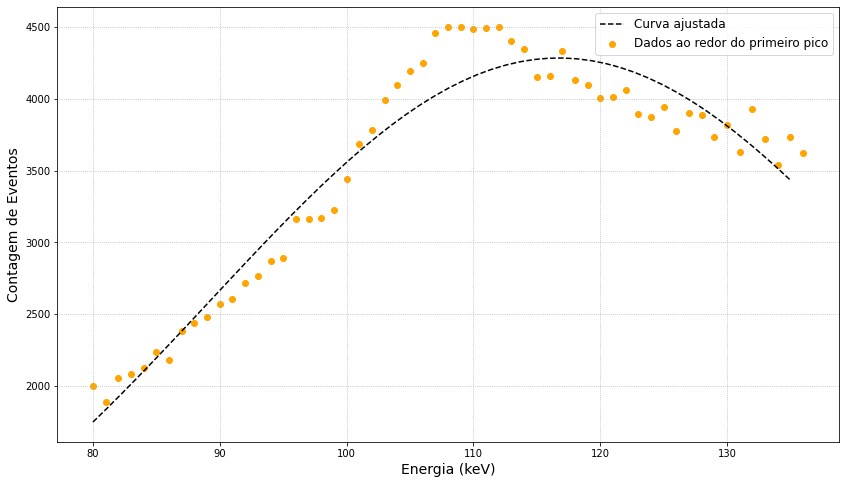

In [221]:
fig = plt.subplots(figsize=(14,8))

x_Back = np.linspace(80, 135)
plt.plot(x_Back, GaussBack(x_Back, *poptBack), linestyle='--', c='black', label='Curva ajustada')
plt.scatter(xdataBack, ydataBack, c='orange', label='Dados ao redor do primeiro pico')
plt.xlabel('Energia (keV)', fontsize='14')
plt.ylabel('Contagem de Eventos', fontsize='14')
plt.legend(fontsize='12')
plt.savefig('PeakFit_Back.png', transparent = True)
plt.grid(linestyle='dotted')

Para encontrar a reta de calibração, é necessário:

1. Determinar os picos de interesse do nuclídeo

2. Selecionar uma seção de área, para que seja possível fazer o ajuste Gaussiano para cada pico, utilizando o _**curve_fit**_.

## 2. Sódio 22

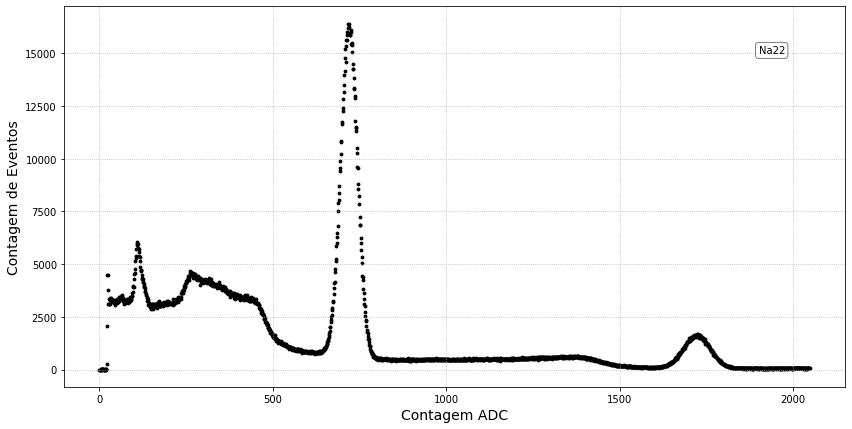

In [222]:
dataNa22 = pd.read_table('Na22.tsv', skiprows=18)

fig, ax = plt.subplots(figsize=(14,7))
plt.scatter(dataNa22['Chan'], dataNa22['Counts'], s=8, color='black')
plt.xlabel('Contagem ADC', fontsize='14')
plt.ylabel('Contagem de Eventos', fontsize='14')
ax.text(1900, 15000, 'Na22', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.savefig('Na22.png', transparent = True)
plt.grid(linestyle='dotted')

###2.1. Gráficos seção de área do Sódio 22

Para que os gráficos abaixo fossem feitos, pegamos pontos ao redor dos picos de modo que não fosse considerado a calda, afinal caso isso tivesse sido feito teriamos que escrever duas gaussianas para cada pico.

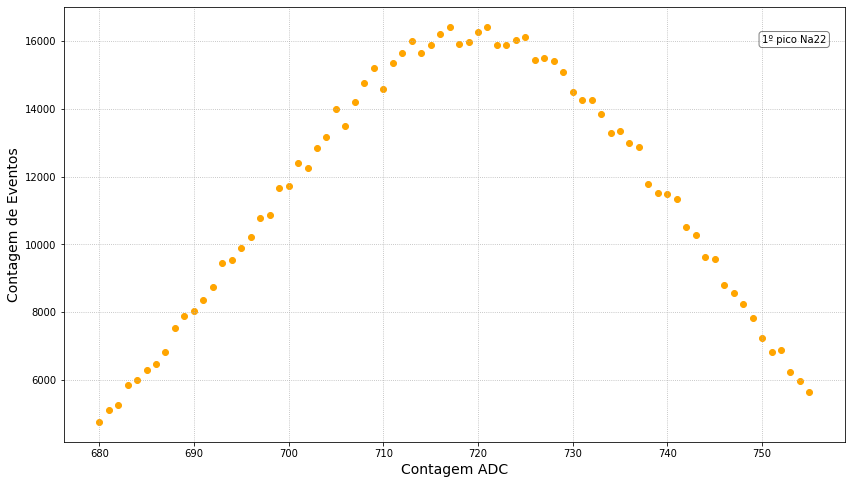

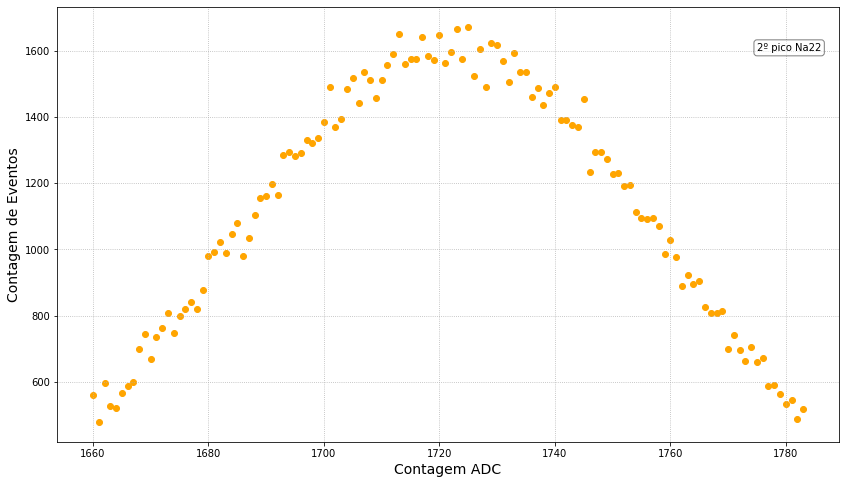

In [272]:
#First peak Na22
data1Na22_peak = dataNa22[(dataNa22['Chan']>=680)&(dataNa22['Chan']<=755)]

fig, ax = plt.subplots(figsize=(14, 8))
plt.scatter(data1Na22_peak['Chan'], data1Na22_peak['Counts'], c='orange')
plt.xlabel('Contagem ADC', fontsize='14')
plt.ylabel('Contagem de Eventos', fontsize='14')
ax.text(750, 15950, '1º pico Na22', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.savefig('Peak1_Na22.png', transparent = True)
plt.grid(linestyle='dotted')

#Second peak Na22
data2Na22_peak = dataNa22[(dataNa22['Chan']>=1660)&(dataNa22['Chan']<=1783)]

fig, ax = plt.subplots(figsize=(14, 8))
plt.scatter(data2Na22_peak['Chan'], data2Na22_peak['Counts'], c='orange')
plt.xlabel('Contagem ADC', fontsize='14')
plt.ylabel('Contagem de Eventos', fontsize='14')
ax.text(1775, 1600, '2º pico Na22', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.savefig('Peak2_Na22.png', transparent = True)
plt.grid(linestyle='dotted')

###2.2. Calibração Sódio 22

#### Primeiro pico

In [225]:
def Gauss1Na22(x, A, mean, sigma): #Gaussiana para o primeiro pico
    return A * np.exp(-0.5 * np.square((x - mean) / sigma))

sigma = np.sqrt(ydata1Na22)
p0 = (1000, 720, 85) #Condições iniciais: valor máximo de y, estimativa da média, xmax - xmin

popt1Na22, pcov1Na22 = curve_fit(Gauss1Na22, xdata1Na22, ydata1Na22, sigma=sigma, p0=p0) #print A, mean, sigma

error1Na22 = [np.sqrt(pcov1Na22[i, i]) for i in np.arange(3)] #Diagonal principal da matriz

In [226]:
popt1Na22

array([16173.03753593,   719.24736626,   -24.66210316])

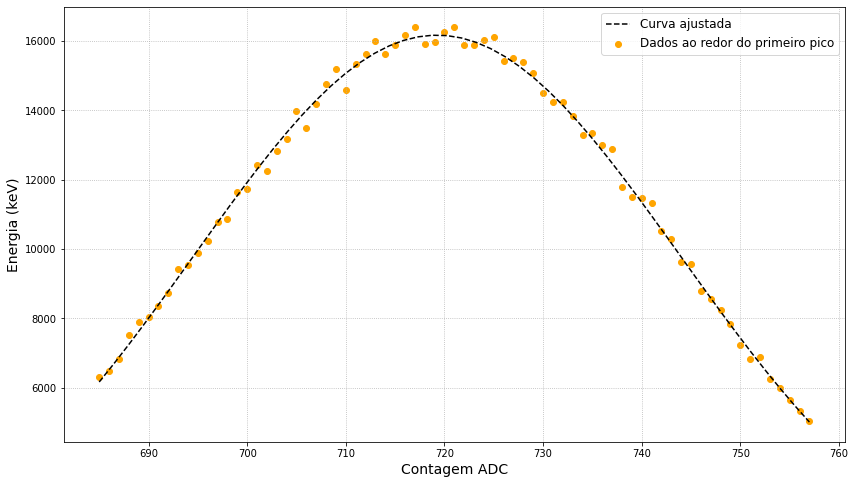

In [227]:
fig = plt.subplots(figsize=(14,8))

x_na1 = np.linspace(685, 757)
plt.plot(x_na1, Gauss1Na22(x_na1, *popt1Na22), linestyle='--', c='black', label='Curva ajustada')
plt.scatter(xdata1Na22, ydata1Na22, c='orange', label='Dados ao redor do primeiro pico')
plt.xlabel('Contagem ADC', fontsize='14')
plt.ylabel('Energia (keV)', fontsize='14')
plt.legend(fontsize='12')
plt.savefig('Peak1Fit_Na22.png', transparent = True)
plt.grid(linestyle='dotted')

#### Segundo Pico

In [228]:
def Gauss2Na22(x, A, mean, sigma): #Gaussiana para o segundo pico
    return A * np.exp(-0.5 * np.square((x - mean) / sigma))

sigma = np.sqrt(ydata2Na22)
p0 = (1000, 1738, 130) #Condições iniciais: valor máximo de y, estimativa da média, xmax - xmin

popt2Na22, pcov2Na22 = curve_fit(Gauss2Na22, xdata2Na22, ydata2Na22, sigma=sigma, p0=p0)

error2Na22 = [np.sqrt(pcov2Na22[i, i]) for i in np.arange(3)]

In [229]:
popt2Na22

array([1600.29666584, 1721.46403433,   39.80736386])

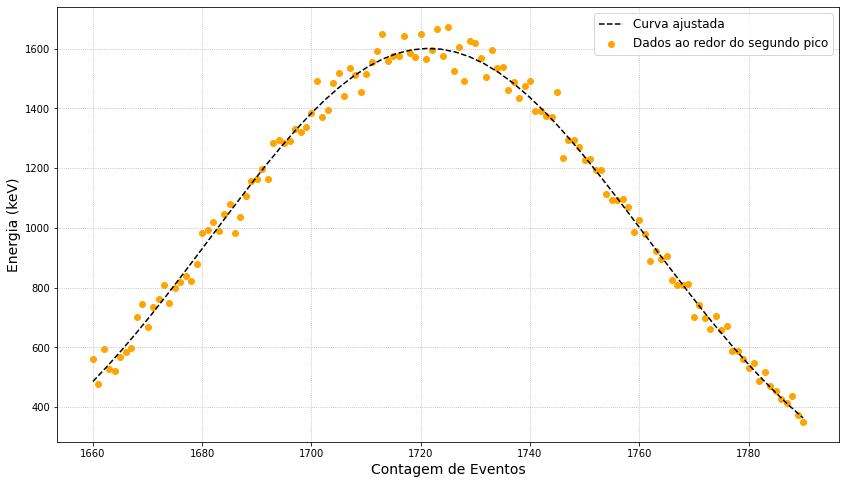

In [276]:
fig = plt.subplots(figsize=(14, 8))

x_na2 = np.linspace(1660, 1790)
plt.plot(x_na2, Gauss2Na22(x_na2, *popt2Na22), linestyle='--', c='black', label='Curva ajustada')
plt.scatter(xdata2Na22, ydata2Na22, c='orange', label='Dados ao redor do segundo pico')
plt.xlabel('Contagem de Eventos', fontsize='14')
plt.ylabel('Energia (keV)', fontsize='14')
plt.legend(fontsize='12')
plt.savefig('Peak2Fit_Na22.png', transparent = True)
plt.grid(linestyle='dotted')

## 3. Césio 137

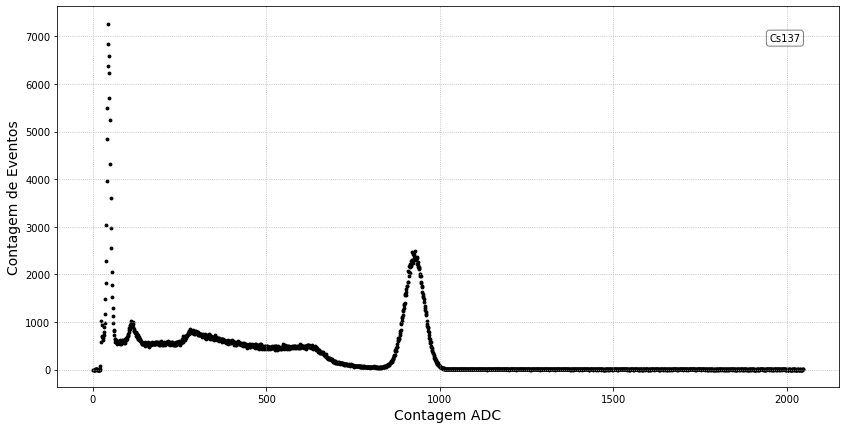

In [231]:
dataCs137 = pd.read_table('Cs137.tsv', skiprows=18)

fig, ax = plt.subplots(figsize=(14,7))
plt.scatter(dataCs137['Chan'], dataCs137['Counts'], s=8, color='black')
plt.xlabel('Contagem ADC', fontsize='14')
plt.ylabel('Contagem de Eventos', fontsize='14')
ax.text(1950, 6900, 'Cs137', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.savefig('Cs137.png', transparent = True)
plt.grid(linestyle='dotted')

###3.1. Gráficos seção de área do Césio 137
Para que o gráfico abaixo fosse feito, pegamos pontos ao redor do pico de modo que não fosse considerado a calda, afinal caso isso tivesse sido feito teriamos que escrever duas gaussianas para o pico.

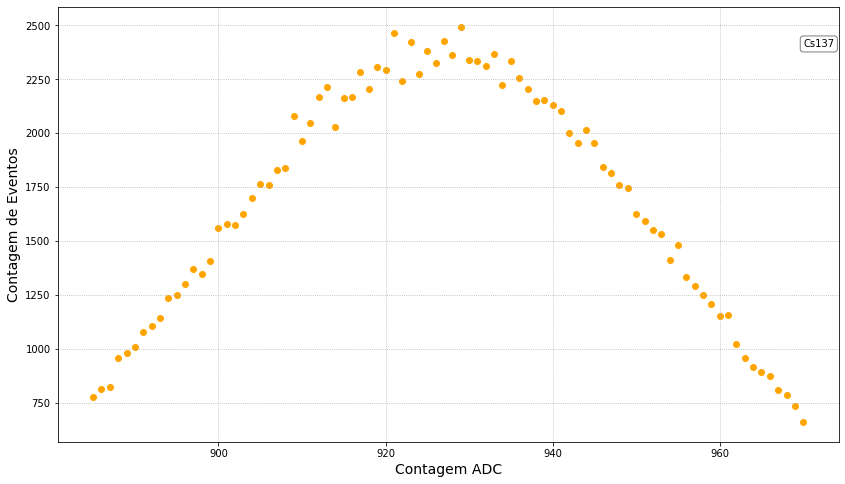

In [282]:
data1Cs137_peak = dataCs137[(dataCs137['Chan']>=885)&(dataCs137['Chan']<=970)]

fig, ax = plt.subplots(figsize=(14,8))
plt.scatter(data1Cs137_peak['Chan'], data1Cs137_peak['Counts'], c='orange')
plt.xlabel('Contagem ADC', fontsize='14')
plt.ylabel('Contagem de Eventos', fontsize='14')
ax.text(970, 2400, 'Cs137', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.savefig('Peak_Cs137.png', transparent = True)
plt.grid(linestyle='dotted')

#### 3.2. Calibração Césio 137

In [283]:
def GaussCs137(x, A, mean, sigma): #Gaussiana para o primeiro pico
    return A * np.exp(-0.5 * np.square((x - mean) / sigma))

sigma = np.sqrt(ydataCs137)
p0 = (1000, 928, 80) #Condições iniciais: valor máximo de y, estimativa da média, xmax - xmin

poptCs137, pcovCs137 = curve_fit(GaussCs137, xdataCs137, ydataCs137, sigma=sigma, p0=p0) #print A, mean, sigma

errorCs137 = [np.sqrt(pcovCs137[i, i]) for i in np.arange(3)] 

In [284]:
poptCs137

array([2381.12049924,  926.45555533,   27.65174927])

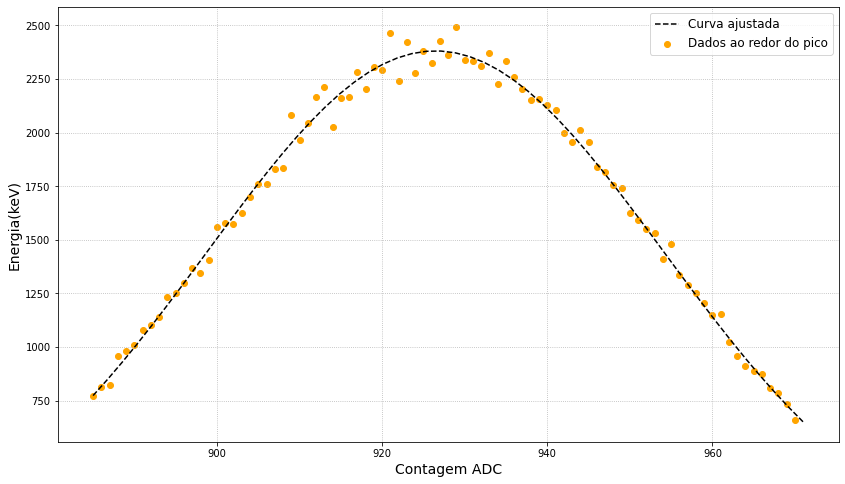

In [287]:
fig = plt.subplots(figsize=(14,8))
x_cs = np.linspace(885, 971)
plt.plot(x_cs, GaussCs137(x_cs, *poptCs137), linestyle='--', c='black', label='Curva ajustada')
plt.scatter(data1Cs137_peak['Chan'], data1Cs137_peak['Counts'], c='orange', label='Dados ao redor do pico')
plt.xlabel('Contagem ADC', fontsize='14')
plt.ylabel('Energia(keV)', fontsize='14')
plt.legend(fontsize='12')
plt.savefig('PeakFit1_Cs137.png', transparent = True)
plt.grid(linestyle='dotted')

## 4. Bário 133

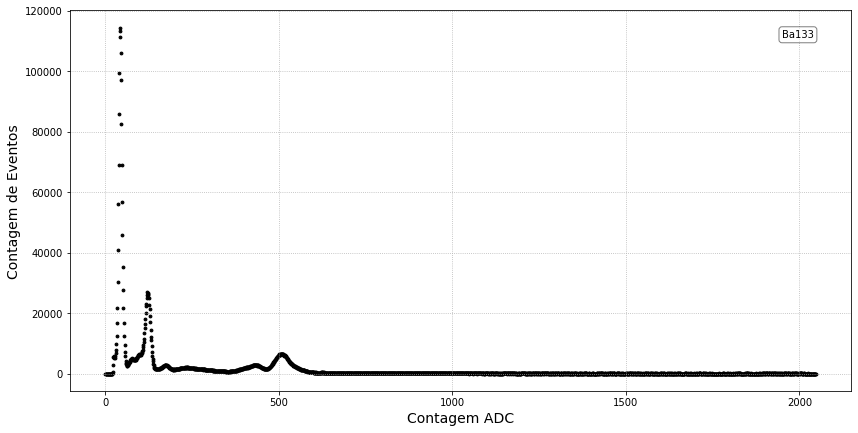

In [237]:
dataBa133 = pd.read_table('Ba133.tsv', skiprows=18)

fig, ax = plt.subplots(figsize=(14,7))
plt.scatter(dataBa133['Chan'], dataBa133['Counts'], s=8, color='black')
plt.xlabel('Contagem ADC', fontsize='14')
plt.ylabel('Contagem de Eventos', fontsize='14')
ax.text(1950, 111000, 'Ba133', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.savefig('Ba133.png', transparent = True)
plt.grid(linestyle='dotted')

In [238]:
print(dataBa133.loc[100:200].nlargest(3, 'Counts'),'\n')
print(dataBa133.loc[100:200]['Counts'].idxmax())
peak1Ba133 = dataBa133.iloc[dataBa133.loc[100:200]['Counts'].idxmax()]['Chan']

print(dataBa133.loc[400:600].nlargest(3, 'Counts'),'\n')
print(dataBa133.loc[400:600]['Counts'].idxmax())
peak2Ba133 = dataBa133.iloc[dataBa133.loc[400:600]['Counts'].idxmax()]['Chan']

     Chan  Unnamed: 1  Counts
121   121         NaN   26945
123   123         NaN   26653
122   122         NaN   26417 

121
     Chan  Unnamed: 1  Counts
507   507         NaN    6590
503   503         NaN    6498
505   505         NaN    6468 

507


**Observação**: No item 1, pode ser visto o pico encontrado para o espectro de fundo, que foi igual a _108_, muito próximo do primeiro pico do espectro do isótopo do Bário 133. Portanto, esse primeiro pico é um ruído e não sinal.

Por isso, não será cálculado a _gaussiana_ desse primeiro pico.

###4.1. Gráficos seção de área do Bário 133

Para que os gráficos abaixo fossem feitos, pegamos pontos ao redor do pico de modo que não fosse considerado a calda, afinal caso isso tivesse sido feito teriamos que escrever duas gaussianas para cada pico.

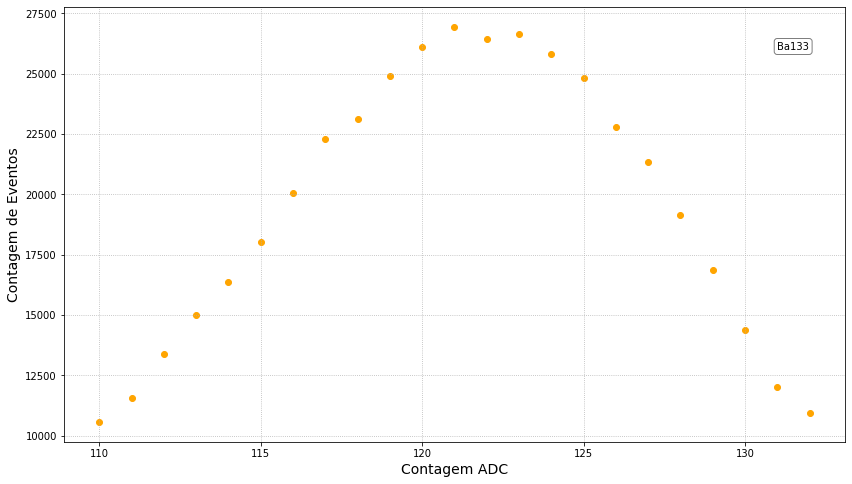

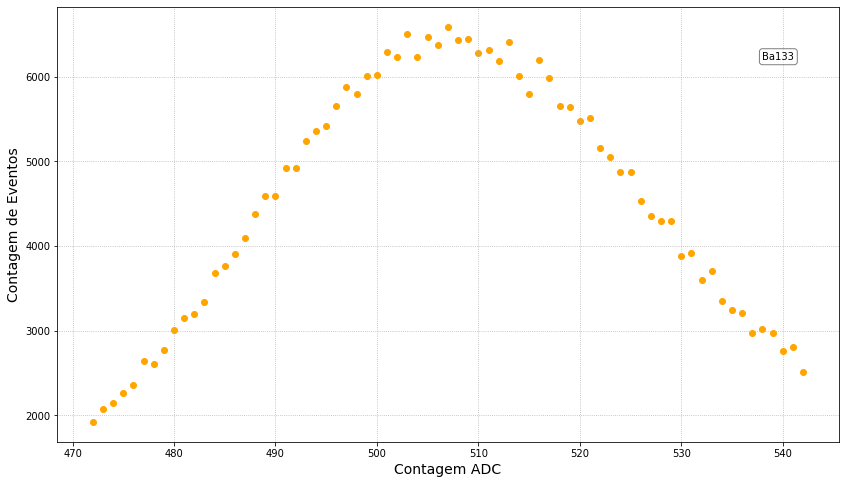

In [239]:
#First peak Ba133
xdata1Ba133 = dataBa133.loc[peak1Ba133 - 11:peak1Ba133 + 11]['Chan']
ydata1Ba133 = dataBa133.loc[peak1Ba133 - 11:peak1Ba133 + 11]['Counts']

fig, ax = plt.subplots(figsize=(14, 8))
plt.scatter(xdata1Ba133, ydata1Ba133, c='orange')
plt.xlabel('Contagem ADC', fontsize='14')
plt.ylabel('Contagem de Eventos', fontsize='14')
ax.text(131, 26000, 'Ba133', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.savefig('Peak1_Ba133.png', transparent = True)
plt.grid(linestyle='dotted')

#Second peak Ba133
xdata2Ba133 = dataBa133.loc[peak2Ba133 - 35:peak2Ba133 + 35]['Chan']
ydata2Ba133 = dataBa133.loc[peak2Ba133 - 35:peak2Ba133 + 35]['Counts']

fig, ax = plt.subplots(figsize=(14, 8))
plt.scatter(xdata2Ba133, ydata2Ba133, c='orange')
plt.xlabel('Contagem ADC', fontsize='14')
plt.ylabel('Contagem de Eventos', fontsize='14')
ax.text(538, 6200, 'Ba133', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.savefig('Peak2_Ba133.png', transparent = True)
plt.grid(linestyle='dotted')

### 4.2 Calibração

1º pico

In [240]:
def Gauss1Ba133(x, A, mean, sigma): #Gaussiana para o segundo pico
    return A * np.exp(-0.5 * np.square((x - mean) / sigma))

sigma = np.sqrt(ydata1Ba133)
p0 = (1000, 122, 25) #Condições iniciais: valor máximo de y, estimativa da média, xmax - xmin

popt1Ba133, pcov1Ba133 = curve_fit(Gauss1Ba133, xdata1Ba133, ydata1Ba133, sigma=sigma, p0=p0)

error1Ba133 = [np.sqrt(pcov1Ba133[i, i]) for i in np.arange(3)]

In [241]:
popt1Ba133

array([ 2.64353658e+04,  1.21464601e+02, -7.96250941e+00])

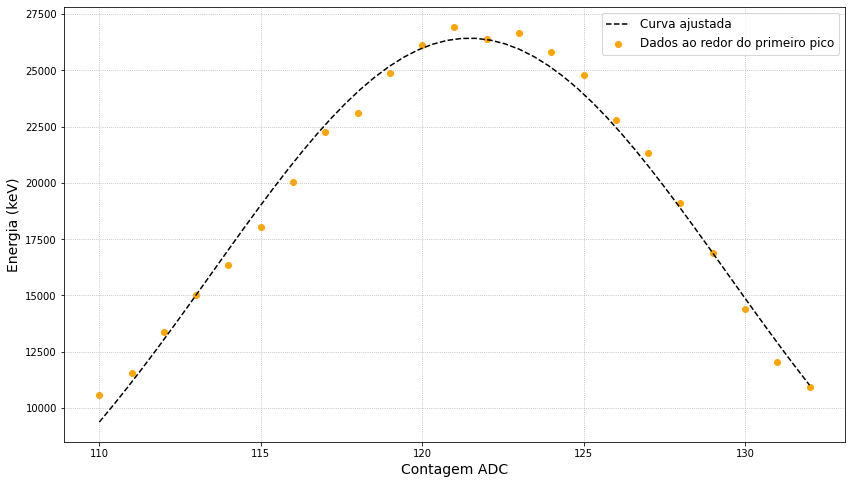

In [242]:
fig = plt.subplots(figsize=(14,8))

x_ba1 = np.linspace(110, 132)
plt.plot(x_ba1, Gauss1Ba133(x_ba1, *popt1Ba133), linestyle='--', c='black', label='Curva ajustada')
plt.scatter(xdata1Ba133, ydata1Ba133, c='orange', label='Dados ao redor do primeiro pico')
plt.xlabel('Contagem ADC', fontsize='14')
plt.ylabel('Energia (keV)', fontsize='14')
plt.legend(fontsize='12')
plt.savefig('Peak1Fit_Ba133.png', transparent = True)
plt.grid(linestyle='dotted')

2º pico

In [243]:
def Gauss2Ba133(x, A, mean, sigma): #Gaussiana para o segundo pico
    return A * np.exp(-0.5 * np.square((x - mean) / sigma))

sigma = np.sqrt(ydata2Ba133)
p0 = (1000, 508, 70) #Condições iniciais: valor máximo de y, estimativa da média, xmax - xmin

popt2Ba133, pcov2Ba133 = curve_fit(Gauss2Ba133, xdata2Ba133, ydata2Ba133, sigma=sigma, p0=p0)

error2Ba133 = [np.sqrt(pcov2Ba133[i, i]) for i in np.arange(3)]

In [244]:
popt2Ba133

array([6344.91955777,  508.38594015,   23.38209675])

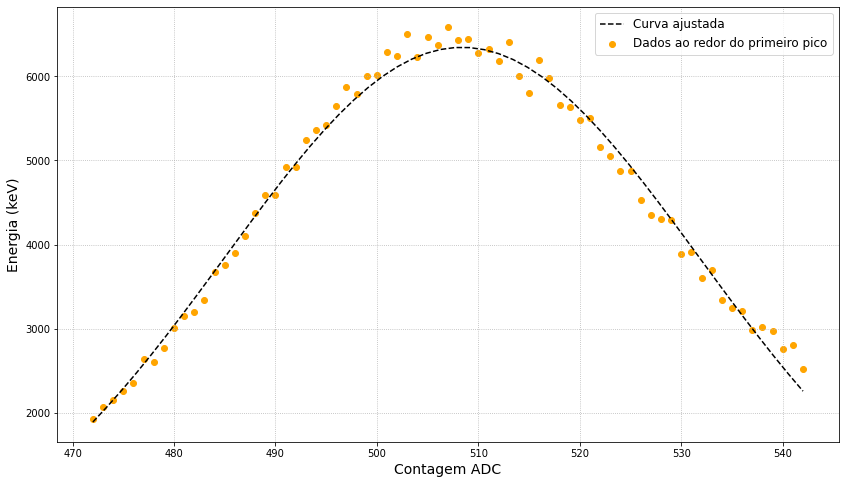

In [245]:
fig = plt.subplots(figsize=(14,8))

x_ba2 = np.linspace(472, 542)
plt.plot(x_ba2, Gauss2Ba133(x_ba2, *popt2Ba133), linestyle='--', c='black', label='Curva ajustada')
plt.scatter(xdata2Ba133, ydata2Ba133, c='orange', label='Dados ao redor do primeiro pico')
plt.xlabel('Contagem ADC', fontsize='14')
plt.ylabel('Energia (keV)', fontsize='14')
plt.legend(fontsize='12')
plt.savefig('Peak2Fit_Ba133.png', transparent = True)
plt.grid(linestyle='dotted')

## 5. Reta Ajustada (Reta de Calibração)

Usando os picos de emissão gama dos isótopos: *ba133*, *Cs137* e *Na22* estimados anteriormente, é possível escrever uma reta de calibração, permitindo que descubramos quais são os isótopos *A*, *B*, *C*, *D* e *E*.

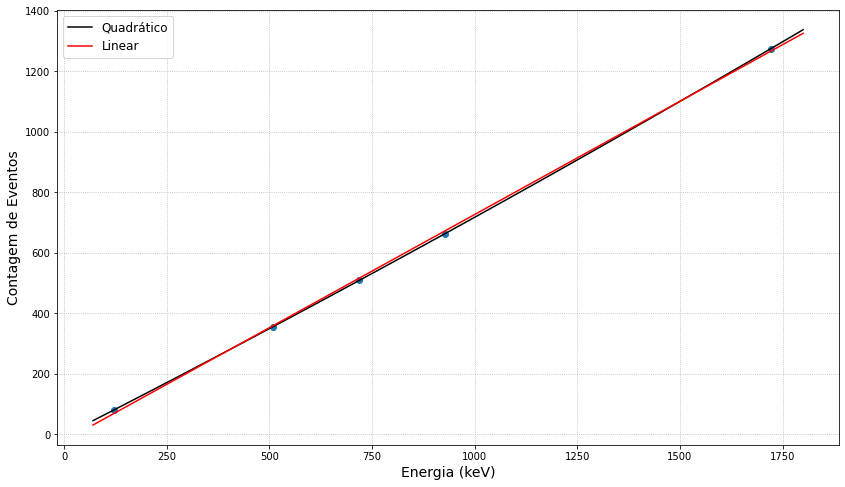

In [246]:
means = [popt1Na22[1], popt2Na22[1], poptCs137[1], popt1Ba133[1], popt2Ba133[1]]
sigmas = [popt1Na22[2], popt2Na22[2], poptCs137[2], popt1Ba133[2], popt2Ba133[2]]
energy = [ 511, 1275, 662, 81, 353 ] #Energia de referência

coef, covar = np.polyfit(means, energy, 1, cov=True)
p = np.poly1d(coef)

coef1, covar1 = np.polyfit(means, energy, 2, cov=True)
p1 = np.poly1d(coef1)

fig = plt.subplots(figsize=(14,8))
xp = np.linspace(70, 1800)
plt.scatter(means, energy)
plt.plot(xp, coef1[0]*np.power(xp, 2) + coef1[1]*xp + coef1[2], color='black', label='Quadrático')
plt.plot(xp, coef[0]*xp + coef[1], color='red', label='Linear')

plt.xlabel('Energia (keV)', fontsize='14')
plt.ylabel('Contagem de Eventos', fontsize='14')
plt.legend(fontsize='12')
plt.grid(linestyle='dotted')

In [247]:
coef, covar

(array([  0.7488301 , -22.21740218]),
 array([[ 8.61911700e-05, -6.89015229e-02],
        [-6.89015229e-02,  7.95076482e+01]]))

In [248]:
coef1, covar1

(array([ 2.99303827e-05,  6.91488564e-01, -3.98786891e+00]),
 array([[ 1.29692842e-11, -2.48469483e-08,  7.89913045e-06],
        [-2.48469483e-08,  5.12406759e-05, -1.80417342e-02],
        [ 7.89913045e-06, -1.80417342e-02,  8.16710577e+00]]))

##6. Isótopos desconhecidos

|     | Isótopo  |  Meia-vida  | Picos de emissão $\gamma$ de interesse |
| :-: | :-----:  |  :-------:  | :------------------------------------: |
| A   |  Eu-150  |  36,9 anos  | 333/ 439 keV                      |
| B   |  Ag-100  |  0,68 anos  | 657/ 937 keV                      |
| C   |  Rb-90m  |  4,3 anos   | 931 keV                           |
| D   |  U-239   |  23,46 min  | 1779 keV                          |
| E   |  Co-57   |  0,74 anos  | 122 keV                           |

###6.1. Isótopo A

Fazendo uma comparação entre os picos de energia de referência e os estimados através do uso da reta de calibração, estima-se que o isótopo A é o isótopo do Európio 150.

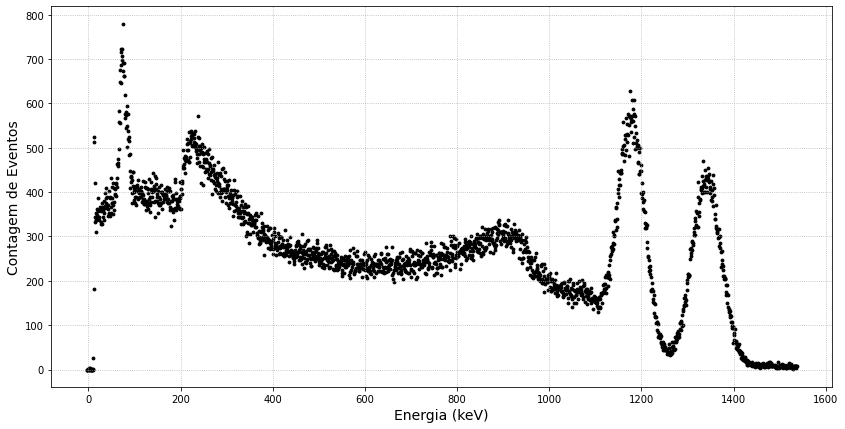

In [249]:
dataA = pd.read_table('A.tsv', skiprows=18)
dataA['Energy'] = coef1[0]*np.power(dataA['Chan'], 2) + coef1[1]*dataA['Chan'] + coef1[2]

fig, ax = plt.subplots(figsize=(14,7))
plt.scatter(dataA['Energy'], dataA['Counts'], s=8, color='black')
plt.ylabel('Contagem de Eventos', fontsize='14')
plt.xlabel('Energia (keV)', fontsize='14')
ax.text(1400, 700, '', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.grid(linestyle='dotted')

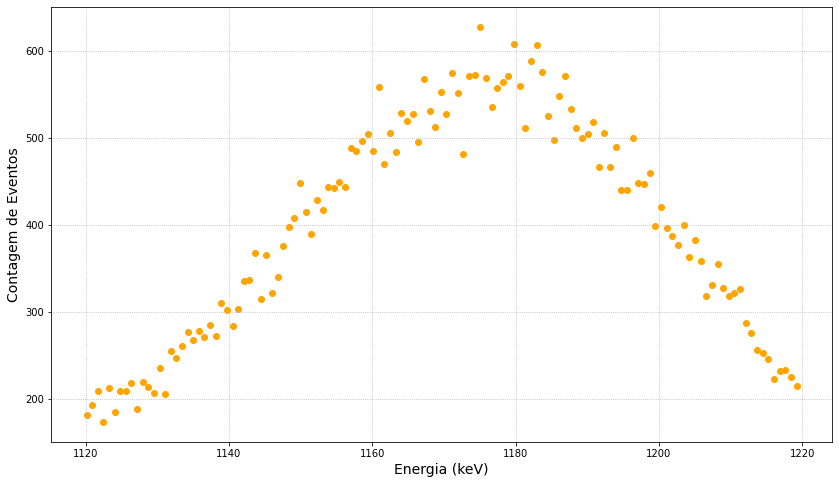

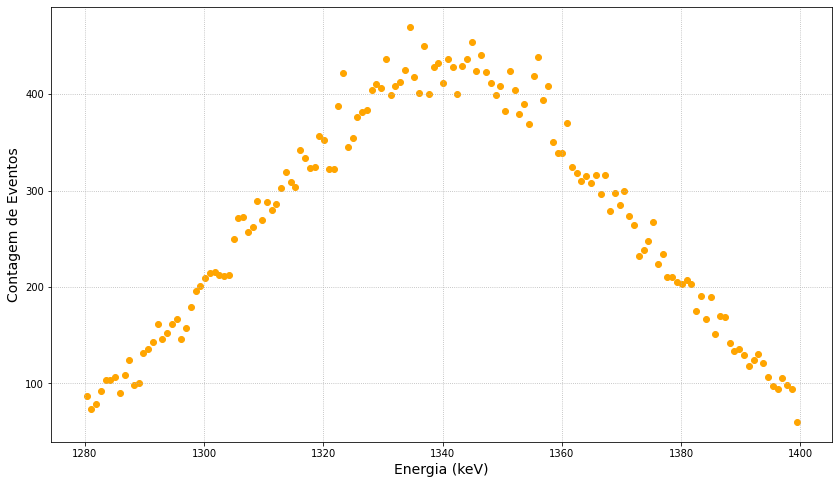

In [250]:
dataA_peak_1 = dataA[(dataA['Energy']>=1120)&(dataA['Energy']<=1220)]
fig = plt.subplots(figsize=(14,8))
plt.scatter(dataA_peak_1['Energy'], dataA_peak_1['Counts'], c='orange')
plt.xlabel('Energia (keV)', fontsize='14')
plt.ylabel('Contagem de Eventos', fontsize='14')
plt.grid(linestyle='dotted')

dataA_peak_2 = dataA[(dataA['Energy']>=1280)&(dataA['Energy']<=1400)]
fig = plt.subplots(figsize=(14,8))
plt.scatter(dataA_peak_2['Energy'], dataA_peak_2['Counts'], c='orange')
plt.xlabel('Energia (keV)', fontsize='14')
plt.ylabel('Contagem de Eventos', fontsize='14')
plt.grid(linestyle='dotted')

In [251]:
def GaussA1(x, A, mean, sigma): #Gaussiana para o primeiro pico
    return A * np.exp(-0.5 * np.square((x - mean) / sigma))

sigma = np.sqrt(dataA_peak_1['Energy'])
p0 = (1000, 1170, 100) #Condições iniciais: valor máximo de y, estimativa da média, xmax - xmin

popt1A, pcov1A = curve_fit(GaussA1, dataA_peak_1['Energy'], dataA_peak_1['Counts'], sigma=sigma, p0=p0) #print A, mean, sigma

error1A = [np.sqrt(pcov1A[i, i]) for i in np.arange(3)]

def GaussA2(x, A, mean, sigma): #Gaussiana para o primeiro pico
    return A * np.exp(-0.5 * np.square((x - mean) / sigma))

sigma = np.sqrt(dataA_peak_2['Energy'])
p0 = (1000, 1335, 120) #Condições iniciais: valor máximo de y, estimativa da média, xmax - xmin

popt2A, pcov2A = curve_fit(GaussA2, dataA_peak_2['Energy'], dataA_peak_2['Counts'], sigma=sigma, p0=p0) #print A, mean, sigma

error2A = [np.sqrt(pcov2A[i, i]) for i in np.arange(3)]

In [252]:
popt1A, popt2A

(array([ 555.33893445, 1175.19963312,  -33.02400328]),
 array([ 427.51644382, 1340.36772071,  -32.58668905]))

###6.2. Isótopo B

Fazendo uma comparação entre os picos de energia de referência e os estimados através do uso da reta de calibração, estima-se que o isótopo B é o isótopo do Argônio 100.

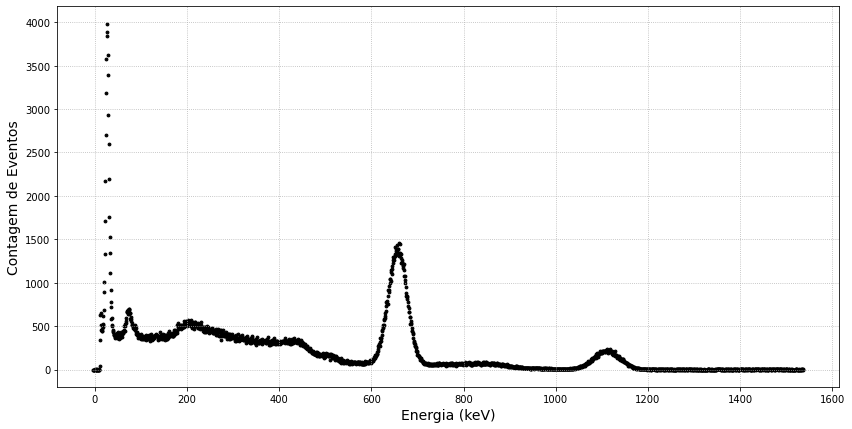

In [253]:
dataB = pd.read_table('B.tsv', skiprows=18)
dataB['Energy'] = coef1[0]*np.power(dataB['Chan'], 2) + coef1[1]*dataB['Chan'] + coef1[2]

fig, ax = plt.subplots(figsize=(14,7))
plt.scatter(dataB['Energy'], dataB['Counts'], s=8, color='black')
plt.ylabel('Contagem de Eventos', fontsize='14')
plt.xlabel('Energia (keV)', fontsize='14')
#ax.text(1400, 1750, 'A', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.grid(linestyle='dotted')

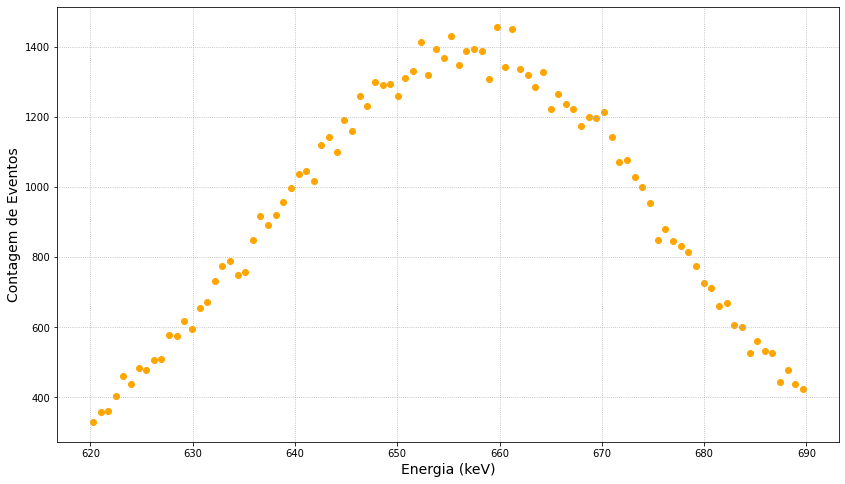

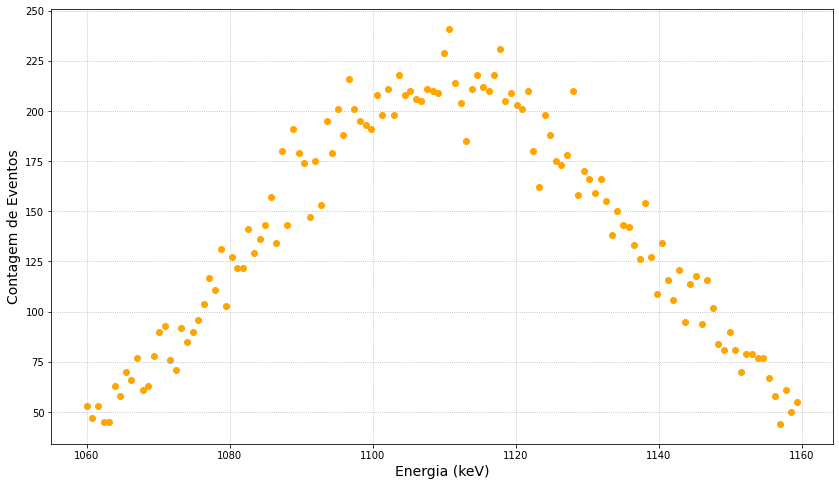

In [254]:
dataB_peak_1 = dataB[(dataB['Energy']>=620)&(dataB['Energy']<=690)]
fig = plt.subplots(figsize=(14,8))
plt.scatter(dataB_peak_1['Energy'], dataB_peak_1['Counts'], c='orange')
plt.xlabel('Energia (keV)', fontsize='14')
plt.ylabel('Contagem de Eventos', fontsize='14')
plt.grid(linestyle='dotted')

dataB_peak_2 = dataB[(dataB['Energy']>=1060)&(dataB['Energy']<=1160)]
fig = plt.subplots(figsize=(14,8))
plt.scatter(dataB_peak_2['Energy'], dataB_peak_2['Counts'], c='orange')
plt.xlabel('Energia (keV)', fontsize='14')
plt.ylabel('Contagem de Eventos', fontsize='14')
plt.grid(linestyle='dotted')

In [255]:
def GaussB1(x, A, mean, sigma): #Gaussiana para o primeiro pico
    return A * np.exp(-0.5 * np.square((x - mean) / sigma))

sigma = np.sqrt(dataB_peak_1['Energy'])
p0 = (1000, 660, 70) #Condições iniciais: valor máximo de y, estimativa da média, xmax - xmin

popt1B, pcov1B = curve_fit(GaussB1, dataB_peak_1['Energy'], dataB_peak_1['Counts'], sigma=sigma, p0=p0) #print A, mean, sigma

error1B = [np.sqrt(pcov1B[i, i]) for i in np.arange(3)]

def GaussB2(x, A, mean, sigma): #Gaussiana para o primeiro pico
    return A * np.exp(-0.5 * np.square((x - mean) / sigma))

sigma = np.sqrt(dataB_peak_2['Energy'])
p0 = (100, 1110, 100) #Condições iniciais: valor máximo de y, estimativa da média, xmax - xmin

popt2B, pcov2B = curve_fit(GaussB2, dataB_peak_2['Energy'], dataB_peak_2['Counts'], sigma=sigma, p0=p0) #print A, mean, sigma

error2B = [np.sqrt(pcov2B[i, i]) for i in np.arange(3)]

In [256]:
popt1B, popt2B

(array([1381.76600589,  656.60898892,  -21.17734052]),
 array([ 214.10231581, 1110.42521217,   28.62415626]))

###6.3. Isótopo C

Fazendo uma comparação entre os picos de energia de referência e os estimados através do uso da reta de calibração, estima-se que o isótopo C é o isótopo do Rubídio 90m

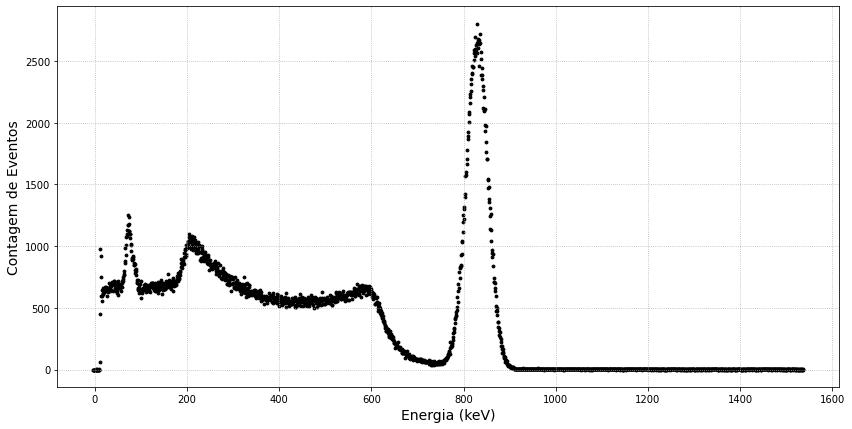

In [257]:
dataC = pd.read_table('C.tsv', skiprows=18)
dataC['Energy'] = coef1[0]*np.power(dataC['Chan'], 2) + coef1[1]*dataC['Chan'] + coef1[2]

fig, ax = plt.subplots(figsize=(14,7))
plt.scatter(dataC['Energy'], dataC['Counts'], s=8, color='black')
plt.xlabel('Energia (keV)', fontsize='14')
plt.ylabel('Contagem de Eventos', fontsize='14')
#ax.text(1400, 1750, 'A', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.grid(linestyle='dotted')

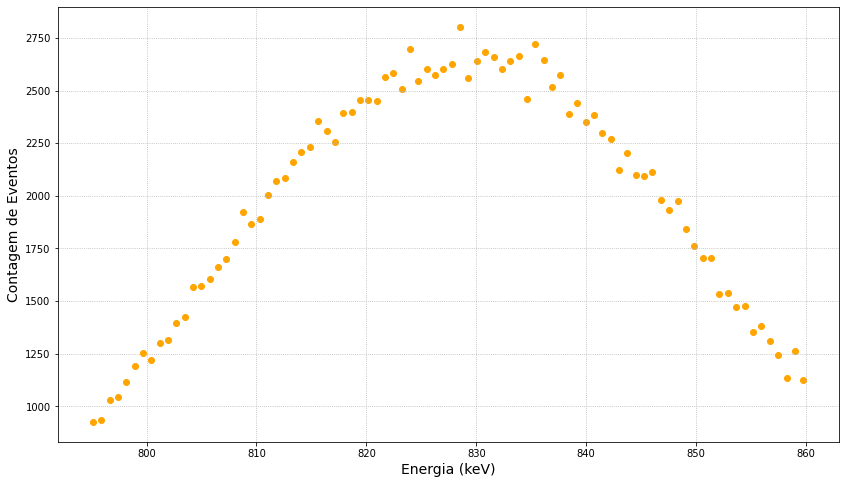

In [258]:
dataC_peak_1 = dataC[(dataC['Energy']>=795)&(dataC['Energy']<=860)]
fig = plt.subplots(figsize=(14,8))
plt.scatter(dataC_peak_1['Energy'], dataC_peak_1['Counts'], c='orange')
plt.xlabel('Energia (keV)', fontsize='14')
plt.ylabel('Contagem de Eventos', fontsize='14')
plt.grid(linestyle='dotted')

In [259]:
def GaussC(x, A, mean, sigma): #Gaussiana para o primeiro pico
    return A * np.exp(-0.5 * np.square((x - mean) / sigma))

sigma = np.sqrt(dataC_peak_1['Energy'])
p0 = (1000, 828, 65) #Condições iniciais: valor máximo de y, estimativa da média, xmax - xmin

poptC, pcovC = curve_fit(GaussC, dataC_peak_1['Energy'], dataC_peak_1['Counts'], sigma=sigma, p0=p0) #print A, mean, sigma

errorC = [np.sqrt(pcovC[i, i]) for i in np.arange(3)]

In [260]:
poptC

array([2665.4740722 ,  828.95000284,   23.25237666])

###6.4. Isótopo **D**

Fazendo uma comparação entre os picos de energia de referência e os estimados através do uso da reta de calibração, estima-se que o isótopo D é o isótopo do Urânio 239.

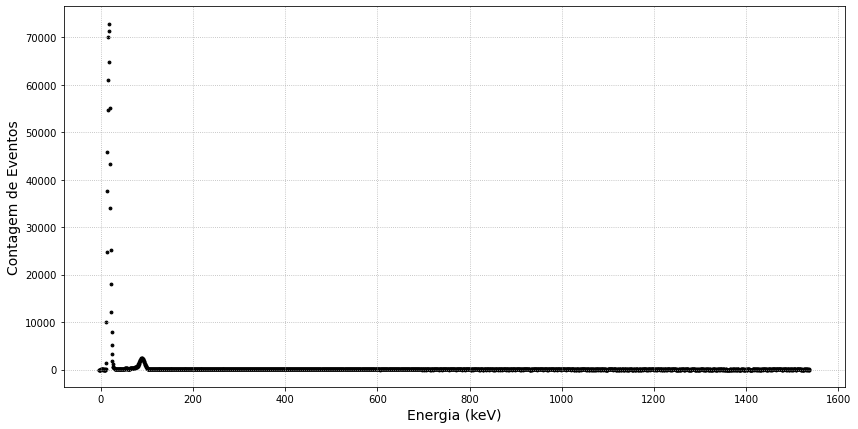

In [261]:
dataD = pd.read_table('D.tsv', skiprows=18)
dataD['Energy'] = coef1[0]*np.power(dataD['Chan'], 2) + coef1[1]*dataD['Chan'] + coef1[2]


fig, ax = plt.subplots(figsize=(14,7))
plt.scatter(dataD['Energy'], dataD['Counts'], s=8, color='black')
plt.xlabel('Energia (keV)', fontsize='14')
plt.ylabel('Contagem de Eventos', fontsize='14')
#ax.text(1400, 1750, 'A', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.grid(linestyle='dotted')

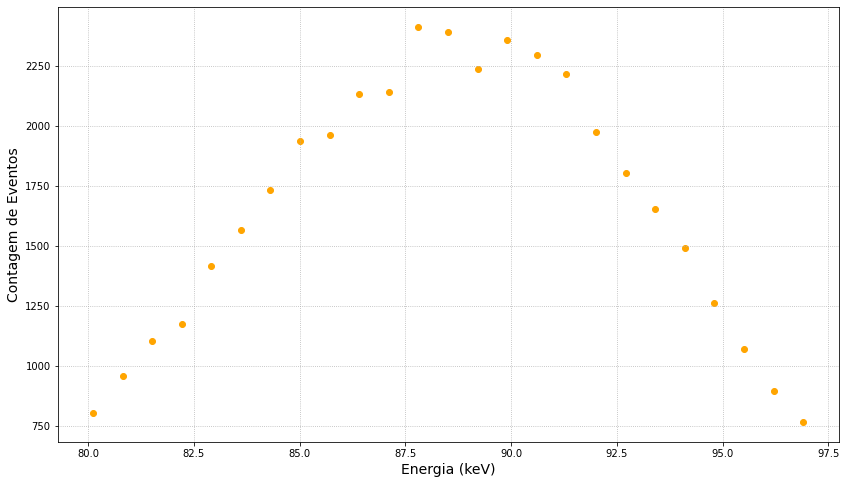

In [262]:
dataD_peak_1 = dataD[(dataD['Energy']>=80)&(dataD['Energy']<=97)]
fig = plt.subplots(figsize=(14,8))
plt.scatter(dataD_peak_1['Energy'], dataD_peak_1['Counts'], c='orange')
plt.xlabel('Energia (keV)', fontsize='14')
plt.ylabel('Contagem de Eventos', fontsize='14')
plt.grid(linestyle='dotted')

In [263]:
def GaussD(x, A, mean, sigma): #Gaussiana para o primeiro pico
    return A * np.exp(-0.5 * np.square((x - mean) / sigma))

sigma = np.sqrt(dataD_peak_1['Energy'])
p0 = (1000, 87.7, 17) #Condições iniciais: valor máximo de y, estimativa da média, xmax - xmin

poptD, pcovD = curve_fit(GaussD, dataD_peak_1['Energy'], dataD_peak_1['Counts'], sigma=sigma, p0=p0) #print A, mean, sigma

errorD = [np.sqrt(pcovD[i, i]) for i in np.arange(3)]

In [264]:
poptD, errorD

(array([2352.30037723,   88.64674172,   -5.62766122]),
 [22.37896427105327, 0.0638813534640891, 0.08117332507464126])

###6.5. Isótopo **E**

Fazendo uma comparação entre os picos de energia de referência e os estimados através do uso da reta de calibração, estima-se que o isótopo E é o isótopo do Cobalto 57.

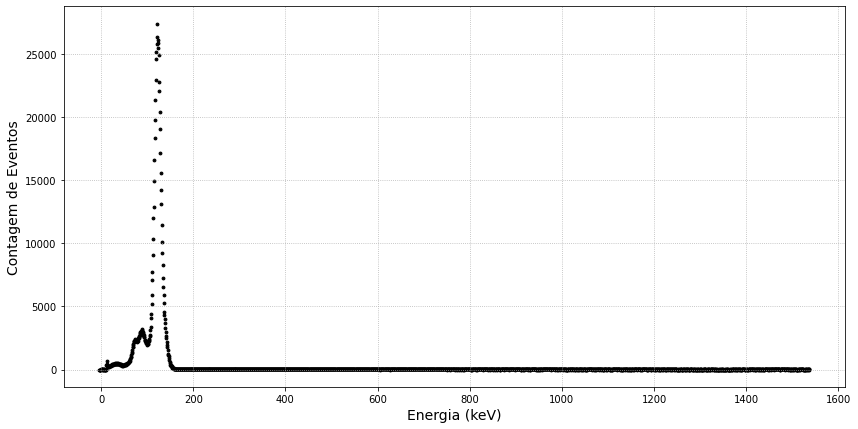

In [265]:
dataE = pd.read_table('E.tsv', skiprows=18)
dataE['Energy'] = coef1[0]*np.power(dataE['Chan'], 2) + coef1[1]*dataE['Chan'] + coef1[2]

fig, ax = plt.subplots(figsize=(14,7))
plt.scatter(dataE['Energy'], dataE['Counts'], s=8, color='black')
plt.xlabel('Energia (keV)', fontsize='14')
plt.ylabel('Contagem de Eventos', fontsize='14')
#ax.text(1400, 1750, 'A', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.grid(linestyle='dotted')

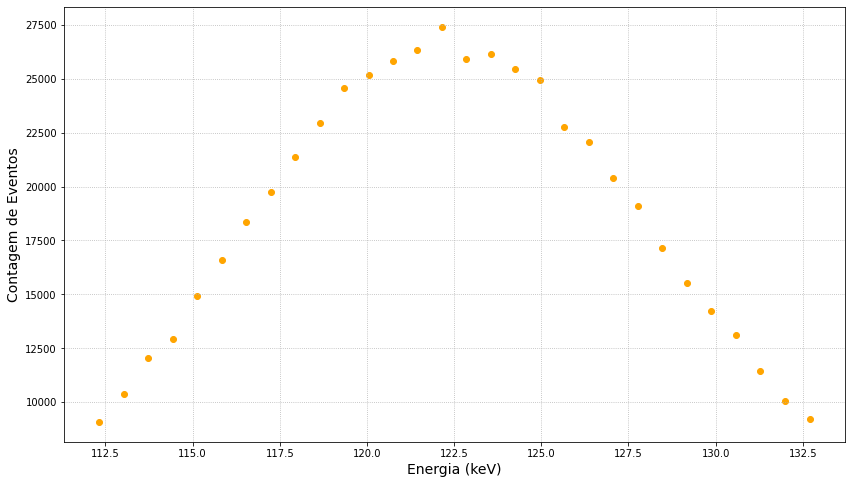

In [266]:
dataE_peak_1 = dataE[(dataE['Energy']>=112)&(dataE['Energy']<=133)]

fig = plt.subplots(figsize=(14,8))
plt.scatter(dataE_peak_1['Energy'], dataE_peak_1['Counts'], c='orange')
plt.xlabel('Energia (keV)', fontsize='14')
plt.ylabel('Contagem de Eventos', fontsize='14')
plt.grid(linestyle='dotted')

In [267]:
def GaussE(x, A, mean, sigma): #Gaussiana para o primeiro pico
    return A * np.exp(-0.5 * np.square((x - mean) / sigma))

sigma = np.sqrt(dataE_peak_1['Energy'])
p0 = (1000, 122.4, 20) #Condições iniciais: valor máximo de y, estimativa da média, xmax - xmin

poptE, pcovE = curve_fit(GaussE, dataE_peak_1['Energy'], dataE_peak_1['Counts'], sigma=sigma, p0=p0) #print A, mean, sigma

errorE = [np.sqrt(pcovE[i, i]) for i in np.arange(3)]

In [268]:
poptE, errorE

(array([ 2.64817260e+04,  1.22343495e+02, -6.80216769e+00]),
 [128.75574390491283, 0.03941019855044209, 0.05034532021872367])